## Abilità Informatiche e Telematiche 2022/2023

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#### lettura del primo set dei tre set di misura simulate

In [2]:
test=1
TEST_COVARIANCE=True
PLOTS=True

In [3]:
Nbins=200
Nmeasures=10000                           # 10000

lettura multipolo 0

In [4]:
measures0 = []
for i in np.arange(Nmeasures)+1:
    fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    #fname = f'C:\\Users\\mario\\Desktop\\Progetto_monaco\\data\\MockMeasures_2PCF_Test{test}\\MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures0.append(table['XI0'])
    if i == 1:
        scale = table['SCALE']
    del table
    file.close()

measures0 = np.asarray(measures0).transpose()

test: controllo array

In [5]:
fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{1}.fits'
file = fits.open(fname)
table = file[1].data.copy()
print(table.shape)

(200,)


In [6]:
measures0.shape

(200, 10000)

calcolo della covarianza numerica e della covarianza numpy

In [7]:
mean_xi_0 = np.mean(measures0,axis=1)
cov_xi_00 = np.cov(measures0)

In [8]:
def cov_num(mat):
    rows,cols = mat.shape
    average = np.zeros((rows,),dtype=float)
    covariance = np.zeros((rows,rows),dtype=float)
    
    for i in range(cols):
        average += mat[:,i]
    average /= cols                     # average = average / cols
    
    for i in range(rows):
        for j in range(rows):
            covariance[i,j] = (np.sum(mat[i]*mat[j]) - average[i]*average[j]*cols) / (cols-1)
    
    return covariance    

test: confronto covarianza numpy e covarianza numerica di una matrice 3x2

In [9]:
matrix=np.array([[1,2],[8,13],[5,6]])

print('matrice 3x2')
print(matrix)

print('covarianza numerica')
print(cov_num(matrix))

print('covarianza numpy')
print(np.cov(matrix))

matrice 3x2
[[ 1  2]
 [ 8 13]
 [ 5  6]]
covarianza numerica
[[ 0.5  2.5  0.5]
 [ 2.5 12.5  2.5]
 [ 0.5  2.5  0.5]]
covarianza numpy
[[ 0.5  2.5  0.5]
 [ 2.5 12.5  2.5]
 [ 0.5  2.5  0.5]]


In [10]:
if TEST_COVARIANCE:
    print('Running test to see if I understand the covariance:')
    cov_mat = cov_num(measures0)
    dif = np.max(np.abs(cov_mat-cov_xi_00))
    # print(f'Largest deviation between my calculation and numpy: {np.max(np.abs(cov_mat-cov_xi))}')
    print(f'Largest deviation between my calculation and numpy: {dif:.3e}')

Running test to see if I understand the covariance:
Largest deviation between my calculation and numpy: 2.871e-13


parametri dei tre set di misure

In [11]:
if test==1:
    sigs = [0.02, 0.02, 0.02]
    ls = [25, 50, 75]
elif test==2:
    sigs = [0.02, 0.01, 0.005]
    ls = [50, 50, 50]
else:
    sigs = [0.02, 0.01, 0.005]
    ls = [5, 5, 5]

autocorrellazione per singolo multipolo e multipolo correlati

In [12]:
def covf(x1, x2, sig, h):
    return sig**2 * np.exp(-(x1 - x2)**2/(2*h**2))

def covf1f2(x1, x2, sig1, h1, sig2, h2):
    den = 1 / (h1**2 + h2**2)
    return sig1*sig2 * np.sqrt(2*h1*h2*den) * np.exp(-(x1-x2)**2*den)
#(np.sqrt(2.*h1*h2)*np.exp(-(np.sqrt((x1 - x2)**2.)**2./(h1**2. + h2**2.)))*sig1*sig2)/np.sqrt(h1**2. + h2**2.)

matrice della covarianza teorica multipolo 00

In [13]:
cov_th_00 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_00[i,j] = covf(scale[i],scale[j],sigs[0],ls[0])

scarto quadratico medio dei residui normalizzati alla varianza

In [14]:
norm_residuals_00 = np.zeros_like(cov_th_00)
corr_00 = np.zeros_like(cov_th_00)
for i in range(Nbins):
    for j in range(Nbins):
        #rho2 = cov_th[i,j]**2./(np.sqrt(cov_th[i,i]*cov_th[j,j])**2.)
        #rho2 = cov_th[i,j]/(np.sqrt(cov_th[i,i]*cov_th[j,j]))
        corr_00[i,j] = cov_xi_00[i,j]/(np.sqrt(cov_xi_00[i,i]*cov_xi_00[j,j]))
        #norm_residuals[i,j]=(cov_th[i,j]-cov_xi[i,j])*np.sqrt((Nmeasures-1.)/((1.+rho2)*cov_th[i,i]*cov_th[j,j]))
        #norm_residuals[i,j]=(cov_th[i,j]-cov_xi[i,j])*np.sqrt((Nmeasures-1)/((1+rho2)*cov_th[i,i]*cov_th[j,j]))
        norm_residuals_00[i,j]=(cov_th_00[i,j]-cov_xi_00[i,j])*(np.sqrt((Nmeasures-1)/((1+corr_00[i,j])*cov_th_00[i,i]*cov_th_00[j,j])))

#rms_deviation=np.std(norm_residuals.reshape(Nbins**2))
rms_deviation_00=np.std(norm_residuals_00)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_00:.3e}')
if rms_deviation_00 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 9.482e-01
**********
* OK *
**********


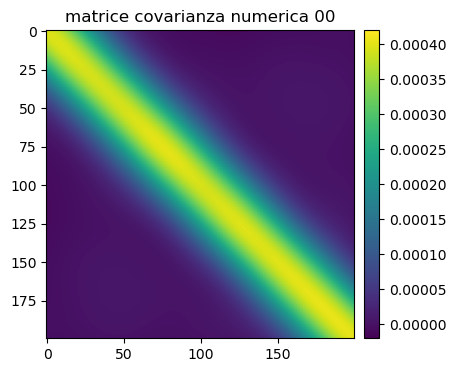

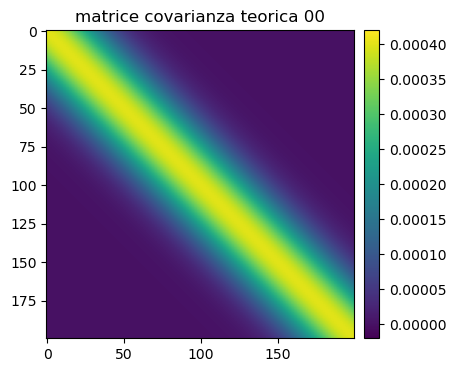

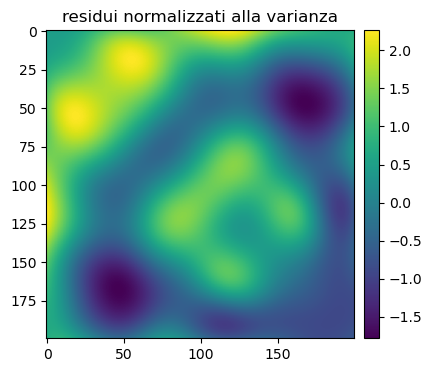

In [15]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_00)*0.05
    cmax =  np.max(cov_th_00)*1.05

    # Plot matrice della covarianza misurata multipolo 00
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 00')
    plt.imshow(cov_xi_00, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 00
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 00')
    plt.imshow(cov_th_00, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_00)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

test

In [16]:
print(cov_xi_00[100,100])
print(cov_xi_00[100,100]*cov_xi_00[100,100])
print(cov_xi_00[100,100]/np.sqrt(cov_xi_00[100,100]*cov_xi_00[100,100]))
print(corr_00[100,100])
print(norm_residuals_00[100,100])

0.0003929488338037588
1.5440878598773404e-07
1.0
1.0
1.2464195325077936


lettura multipolo 2

In [17]:
measures2 = []
for i in np.arange(Nmeasures)+1:
    fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures2.append(table['XI2'])
    file.close()

measures2 = np.asarray(measures2).transpose()

matrice della covarianza numerica multipolo 22

In [18]:
mean_xi_2 = np.mean(measures2,axis=1)
cov_xi_22 = np.cov(measures2)

matrice della covarianza teorica multipolo 22

In [19]:
cov_th_22 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_22[i,j] = covf(scale[i],scale[j],sigs[1],ls[1])

scarto quadratico medio dei residui normalizzati alla varianza

In [20]:
norm_residuals_22 = np.zeros_like(cov_th_22)
for i in range(Nbins):
    for j in range(Nbins):
        corr_22 = cov_xi_22[i,j]/(np.sqrt(cov_xi_22[i,i]*cov_xi_22[j,j]))
        norm_residuals_22[i,j]=(cov_th_22[i,j]-cov_xi_22[i,j])*np.sqrt((Nmeasures-1)/((1+corr_22)*cov_th_22[i,i]*cov_th_22[j,j]))

rms_deviation_22=np.std(norm_residuals_22)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_22:.3e}')
if rms_deviation_22 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 7.138e-01
**********
* OK *
**********


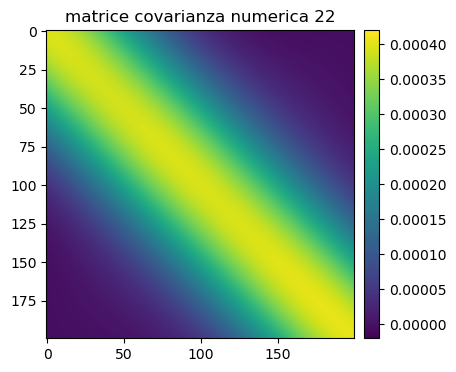

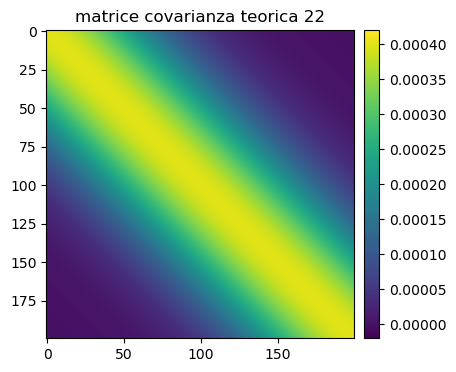

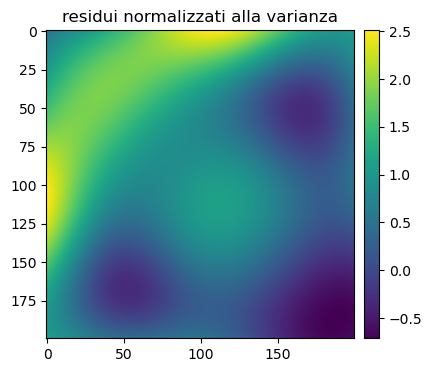

In [21]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_22)*0.05
    cmax =  np.max(cov_th_22)*1.05

    # Plot matrice della covarianza misurata multipolo 22
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 22')
    plt.imshow(cov_xi_22, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 22
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 22')
    plt.imshow(cov_th_22, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_22)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

lettura multipolo 4

In [22]:
measures4 = []
for i in np.arange(Nmeasures)+1:
    fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures4.append(table['XI4'])
    file.close()

measures4 = np.asarray(measures4).transpose()

matrice della covarianza numerica multipolo 44

In [23]:
mean_xi_4 = np.mean(measures4,axis=1)
cov_xi_44 = np.cov(measures4)

matrice della covarianza teorica multipolo 44

In [24]:
cov_th_44 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_44[i,j] = covf(scale[i],scale[j],sigs[2],ls[2])

scarto quadratico medio dei residui normalizzati alla varianza

In [25]:
norm_residuals_44 = np.zeros_like(cov_th_44)
for i in range(Nbins):
    for j in range(Nbins):
        corr_44 = cov_xi_44[i,j]/(np.sqrt(cov_xi_44[i,i]*cov_xi_44[j,j]))
        norm_residuals_44[i,j]=(cov_th_44[i,j]-cov_xi_44[i,j])*np.sqrt((Nmeasures-1)/((1+corr_44)*cov_th_44[i,i]*cov_th_44[j,j]))

rms_deviation_44=np.std(norm_residuals_44)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_44:.3e}')
if rms_deviation_44 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 5.559e-01
**********
* OK *
**********


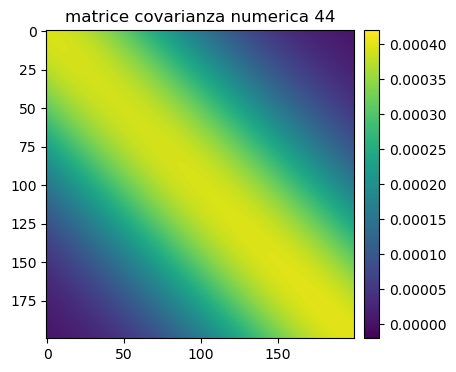

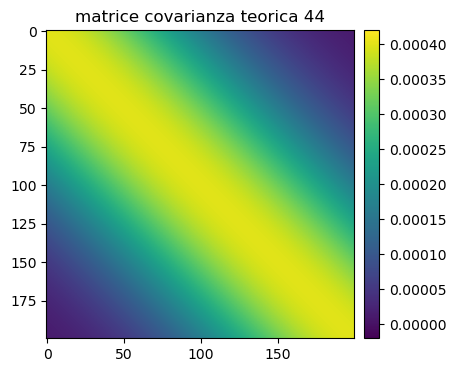

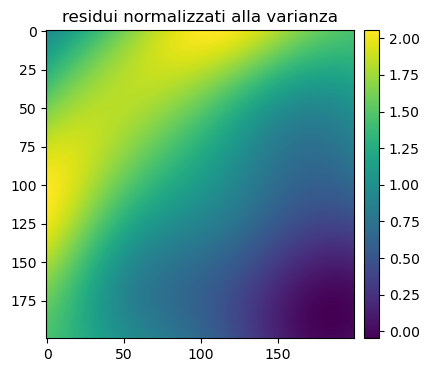

In [26]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_44)*0.05
    cmax =  np.max(cov_th_44)*1.05

    # Plot matrice della covarianza misurata multipolo 44
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 44')
    plt.imshow(cov_xi_44, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 44
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 44')
    plt.imshow(cov_th_44, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_44)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

In [27]:
print(cov_xi_44[100,100])
print(cov_th_44[100,100])
print(cov_xi_44[100,100]*cov_xi_44[100,100])
print(cov_xi_44[100,100]/np.sqrt(cov_xi_44[100,100]*cov_xi_44[100,100]))
#print(corr_44[100,100])
print(norm_residuals_44[100,100])

0.0003938437454206004
0.0004
1.5511289580692672e-07
1.0
1.0882279244736315


cross-correlazioni

In [28]:
def cov_num_cr(mat_0,mat_2):
    rows,cols = mat_0.shape
    average_0 = np.zeros((rows,),dtype=float)
    average_2 = np.zeros((rows,),dtype=float)
    covariance = np.zeros((rows,rows),dtype=float)
    
    for i in range(cols):
        average_0 += mat_0[:,i]
        average_2 += mat_2[:,i]
    average_0 /= cols                     # average = average / cols
    average_2 /= cols                     # average = average / cols

    
    for i in range(rows):
        for j in range(rows):
            covariance[i,j] = (np.sum(mat_0[i]*mat_2[j]) - average_0[i]*average_2[j]*cols) / (cols-1)
    
    return covariance    

matrice della covarianza numerica multipolo 02

In [29]:
cov_xi_02 = cov_num_cr(measures0,measures2)

matrice della covarianza teorica multipolo 02

In [30]:
cov_th_02 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_02[i,j] = covf1f2(scale[i],scale[j],sigs[0],ls[0],sigs[1],ls[1])

scarto quadratico medio dei residui normalizzati alla varianza

In [31]:
norm_residuals_02 = np.zeros_like(cov_th_02)
for i in range(Nbins):
    for j in range(Nbins):
        corr_02 = cov_xi_02[i,j]/(np.sqrt(cov_xi_02[i,i]*cov_xi_02[j,j]))
        norm_residuals_02[i,j]=(cov_th_02[i,j]-cov_xi_02[i,j])*np.sqrt((Nmeasures-1)/((1+corr_02)*cov_th_02[i,i]*cov_th_02[j,j]))

rms_deviation_02=np.std(norm_residuals_02)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_02:.3e}')
if rms_deviation_02 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 9.860e-01
**********
* OK *
**********


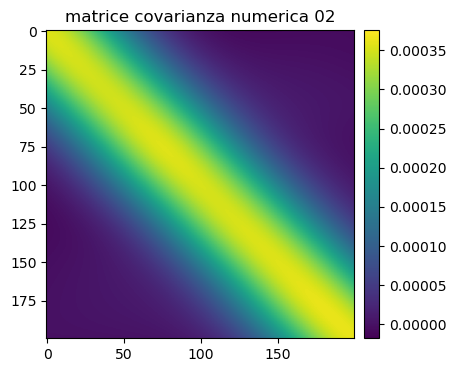

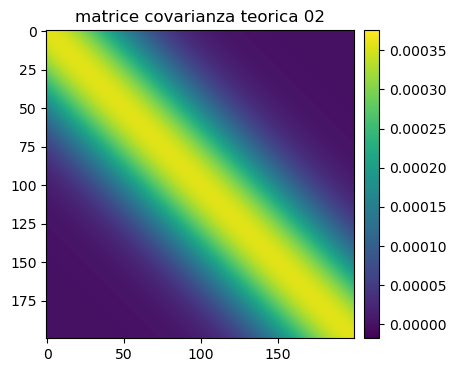

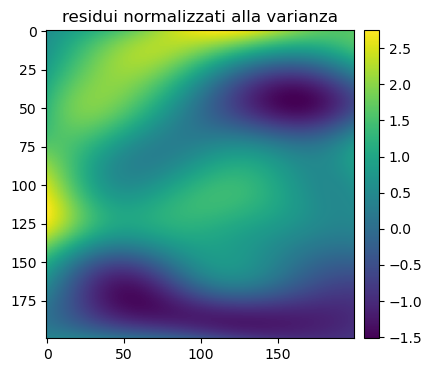

In [32]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_02)*0.05
    cmax =  np.max(cov_th_02)*1.05

    # Plot matrice della covarianza misurata multipolo 02
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 02')
    plt.imshow(cov_xi_02, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 02
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 02')
    plt.imshow(cov_th_02, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_02)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

matrice della covarianza numerica multipolo 04

In [33]:
cov_xi_04 = cov_num_cr(measures0,measures4)

matrice della covarianza teorica multipolo 04

In [34]:
cov_th_04 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_04[i,j] = covf1f2(scale[i],scale[j],sigs[0],ls[0],sigs[2],ls[2])

scarto quadratico medio dei residui normalizzati alla varianza

In [35]:
norm_residuals_04 = np.zeros_like(cov_th_04)
for i in range(Nbins):
    for j in range(Nbins):
        corr_04 = cov_xi_04[i,j]/(np.sqrt(cov_xi_04[i,i]*cov_xi_04[j,j]))
        norm_residuals_04[i,j]=(cov_th_04[i,j]-cov_xi_04[i,j])*np.sqrt((Nmeasures-1)/((1+corr_04)*cov_th_04[i,i]*cov_th_04[j,j]))

rms_deviation_04=np.std(norm_residuals_04)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_04:.3e}')
if rms_deviation_04 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 1.087e+00
**********
* OK *
**********


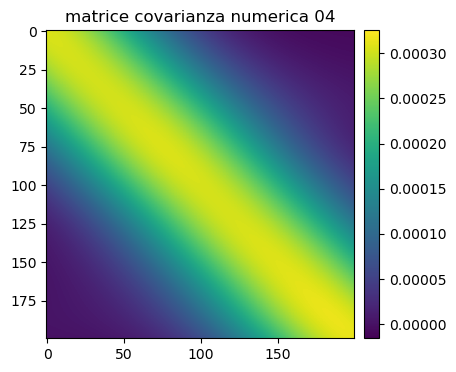

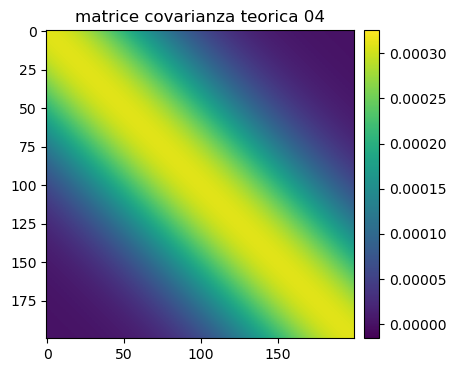

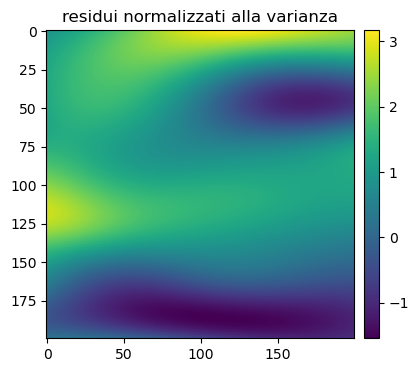

In [36]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_04)*0.05
    cmax =  np.max(cov_th_04)*1.05

    # Plot matrice della covarianza misurata multipolo 04
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 04')
    plt.imshow(cov_xi_04, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 04
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 04')
    plt.imshow(cov_th_04, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_04)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

matrice della covarianza numerica multipolo 24

In [37]:
cov_xi_24 = cov_num_cr(measures2,measures4)

matrice della covarianza teorica multipolo 24

In [38]:
cov_th_24 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_24[i,j] = covf1f2(scale[i],scale[j],sigs[1],ls[1],sigs[2],ls[2])

scarto quadratico medio dei residui normalizzati alla varianza

In [39]:
norm_residuals_24 = np.zeros_like(cov_th_24)
for i in range(Nbins):
    for j in range(Nbins):
        corr_24 = cov_xi_24[i,j]/(np.sqrt(cov_xi_24[i,i]*cov_xi_24[j,j]))
        norm_residuals_24[i,j]=(cov_th_24[i,j]-cov_xi_24[i,j])*np.sqrt((Nmeasures-1)/((1+corr_24)*cov_th_24[i,i]*cov_th_24[j,j]))

rms_deviation_24=np.std(norm_residuals_24)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_24:.3e}')
if rms_deviation_24 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 6.611e-01
**********
* OK *
**********


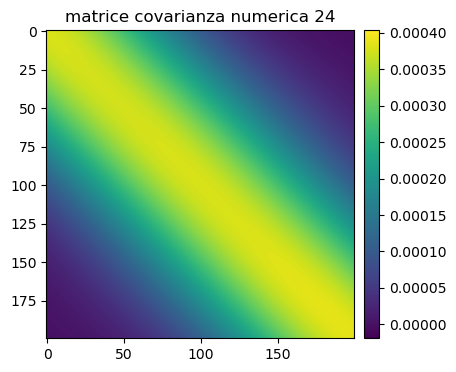

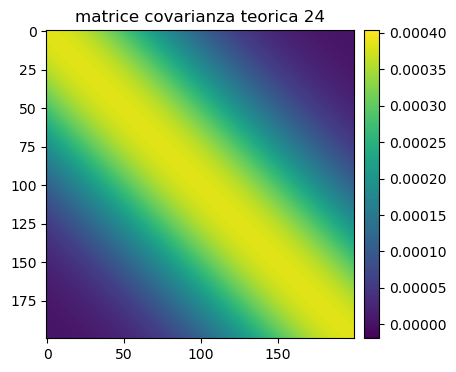

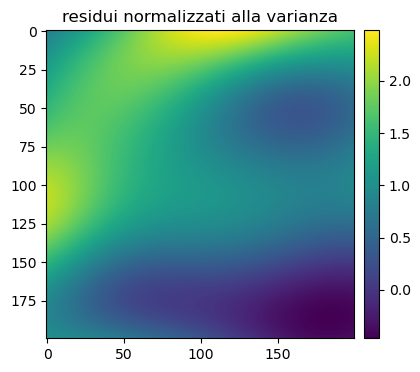

In [40]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_24)*0.05
    cmax =  np.max(cov_th_24)*1.05

    # Plot matrice della covarianza misurata multipolo 24
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 24')
    plt.imshow(cov_xi_24, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 24
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 24')
    plt.imshow(cov_th_24, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_24)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

#### lettura del secondo set dei tre set di misura simulate

In [41]:
test=2

lettura multipolo 0

In [42]:
measures0 = []
for i in np.arange(Nmeasures)+1:
    fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures0.append(table['XI0'])
    if i == 1:
        scale = table['SCALE']
    del table
    file.close()

measures0 = np.asarray(measures0).transpose()

test: controllo array

In [43]:
fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{1}.fits'
file = fits.open(fname)
table = file[1].data.copy()
print(table.shape)

(200,)


In [44]:
measures0.shape

(200, 10000)

calcolo della covarianza numerica e della covarianza numpy

In [45]:
mean_xi_0 = np.mean(measures0,axis=1)
cov_xi_00 = np.cov(measures0)

In [46]:
if TEST_COVARIANCE:
    print('Running test to see if I understand the covariance:')
    cov_mat = cov_num(measures0)
    dif = np.max(np.abs(cov_mat-cov_xi_00))
    # print(f'Largest deviation between my calculation and numpy: {np.max(np.abs(cov_mat-cov_xi))}')
    print(f'Largest deviation between my calculation and numpy: {dif:.3e}')

Running test to see if I understand the covariance:
Largest deviation between my calculation and numpy: 3.150e-13


parametri dei tre set di misure

In [47]:
if test==1:
    sigs = [0.02, 0.02, 0.02]
    ls = [25, 50, 75]
elif test==2:
    sigs = [0.02, 0.01, 0.005]
    ls = [50, 50, 50]
else:
    sigs = [0.02, 0.01, 0.005]
    ls = [5, 5, 5]

matrice della covarianza teorica multipolo 00

In [48]:
cov_th_00 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_00[i,j] = covf(scale[i],scale[j],sigs[0],ls[0])

scarto quadratico medio dei residui normalizzati alla varianza

In [49]:
norm_residuals_00 = np.zeros_like(cov_th_00)
corr_00 = np.zeros_like(cov_th_00)
for i in range(Nbins):
    for j in range(Nbins):
        corr_00[i,j] = cov_xi_00[i,j]/(np.sqrt(cov_xi_00[i,i]*cov_xi_00[j,j]))
        norm_residuals_00[i,j]=(cov_th_00[i,j]-cov_xi_00[i,j])*(np.sqrt((Nmeasures-1)/((1+corr_00[i,j])*cov_th_00[i,i]*cov_th_00[j,j])))
        
rms_deviation_00=np.std(norm_residuals_00)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_00:.3e}')
if rms_deviation_00 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 6.178e-01
**********
* OK *
**********


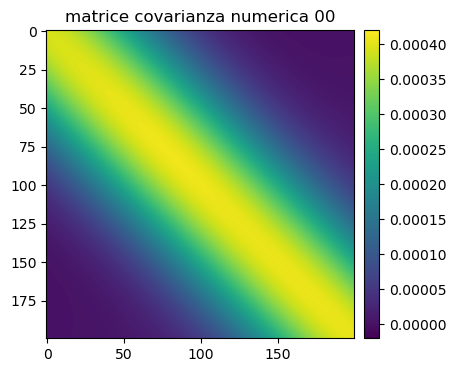

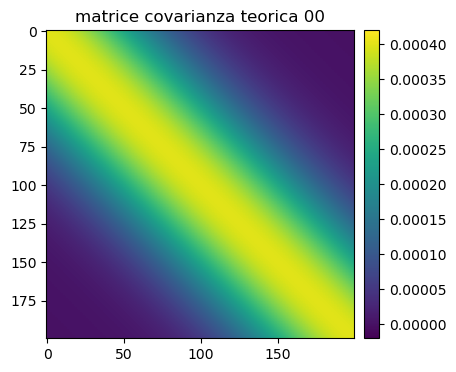

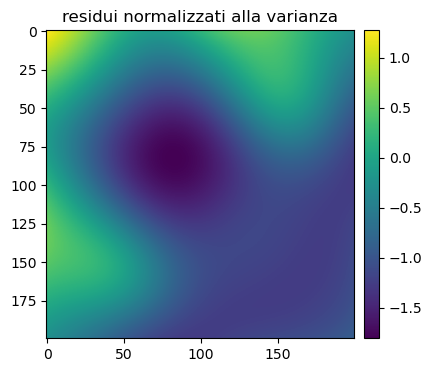

In [50]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_00)*0.05
    cmax =  np.max(cov_th_00)*1.05

    # Plot matrice della covarianza misurata multipolo 00
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 00')
    plt.imshow(cov_xi_00, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 00
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 00')
    plt.imshow(cov_th_00, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_00)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

test

In [51]:
print(cov_xi_00[100,100])
print(cov_xi_00[100,100]*cov_xi_00[100,100])
print(cov_xi_00[100,100]/np.sqrt(cov_xi_00[100,100]*cov_xi_00[100,100]))
print(corr_00[100,100])
print(norm_residuals_00[100,100])

0.00040912571224969047
1.6738384842381652e-07
1.0
1.0
-1.613132591049012


lettura multipolo 2

In [52]:
measures2 = []
for i in np.arange(Nmeasures)+1:
    fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures2.append(table['XI2'])
    file.close()

measures2 = np.asarray(measures2).transpose()

matrice della covarianza numerica multipolo 22

In [53]:
mean_xi_2 = np.mean(measures2,axis=1)
cov_xi_22 = np.cov(measures2)

matrice della covarianza teorica multipolo 22

In [54]:
cov_th_22 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_22[i,j] = covf(scale[i],scale[j],sigs[1],ls[1])

scarto quadratico medio dei residui normalizzati alla varianza

In [55]:
norm_residuals_22 = np.zeros_like(cov_th_22)
for i in range(Nbins):
    for j in range(Nbins):
        corr_22 = cov_xi_22[i,j]/(np.sqrt(cov_xi_22[i,i]*cov_xi_22[j,j]))
        norm_residuals_22[i,j]=(cov_th_22[i,j]-cov_xi_22[i,j])*np.sqrt((Nmeasures-1)/((1+corr_22)*cov_th_22[i,i]*cov_th_22[j,j]))

rms_deviation_22=np.std(norm_residuals_22)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_22:.3e}')
if rms_deviation_22 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 6.178e-01
**********
* OK *
**********


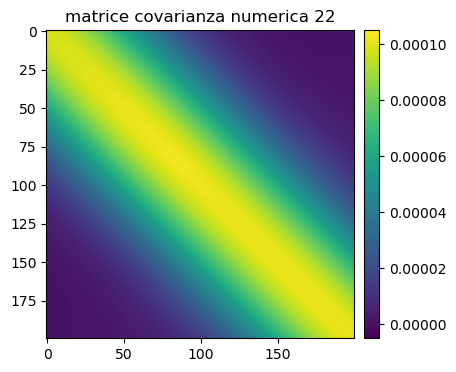

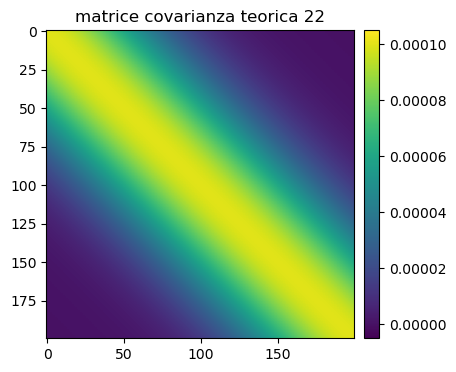

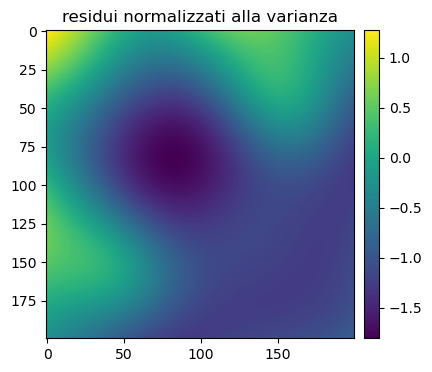

In [56]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_22)*0.05
    cmax =  np.max(cov_th_22)*1.05

    # Plot matrice della covarianza misurata multipolo 22
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 22')
    plt.imshow(cov_xi_22, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 22
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 22')
    plt.imshow(cov_th_22, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_22)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

lettura multipolo 4

In [57]:
measures4 = []
for i in np.arange(Nmeasures)+1:
    fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures4.append(table['XI4'])
    file.close()

measures4 = np.asarray(measures4).transpose()

matrice della covarianza numerica multipolo 44

In [58]:
mean_xi_4 = np.mean(measures4,axis=1)
cov_xi_44 = np.cov(measures4)

matrice della covarianza teorica multipolo 44

In [59]:
cov_th_44 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_44[i,j] = covf(scale[i],scale[j],sigs[2],ls[2])

scarto quadratico medio dei residui normalizzati alla varianza

In [60]:
norm_residuals_44 = np.zeros_like(cov_th_44)
for i in range(Nbins):
    for j in range(Nbins):
        corr_44 = cov_xi_44[i,j]/(np.sqrt(cov_xi_44[i,i]*cov_xi_44[j,j]))
        norm_residuals_44[i,j]=(cov_th_44[i,j]-cov_xi_44[i,j])*np.sqrt((Nmeasures-1)/((1+corr_44)*cov_th_44[i,i]*cov_th_44[j,j]))

rms_deviation_44=np.std(norm_residuals_44)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_44:.3e}')
if rms_deviation_44 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 6.178e-01
**********
* OK *
**********


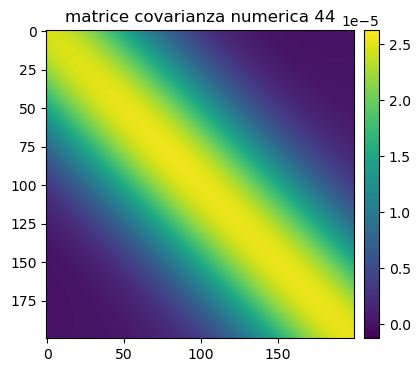

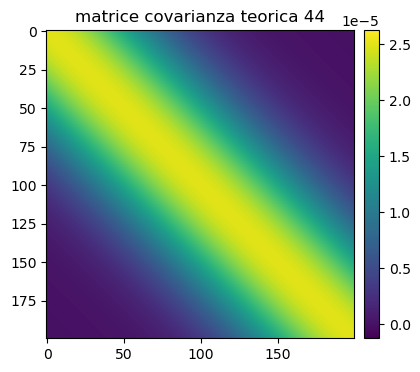

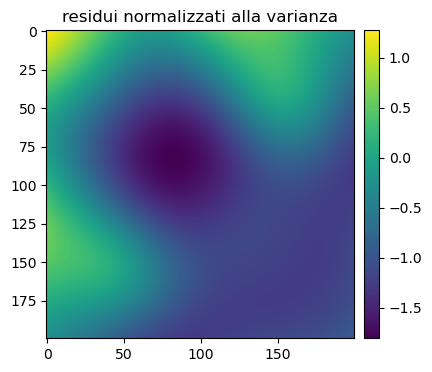

In [61]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_44)*0.05
    cmax =  np.max(cov_th_44)*1.05

    # Plot matrice della covarianza misurata multipolo 44
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 44')
    plt.imshow(cov_xi_44, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 44
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 44')
    plt.imshow(cov_th_44, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_44)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

In [62]:
print(cov_xi_44[100,100])
print(cov_th_44[100,100])
print(cov_xi_44[100,100]*cov_xi_44[100,100])
print(cov_xi_44[100,100]/np.sqrt(cov_xi_44[100,100]*cov_xi_44[100,100]))
#print(corr_44[100,100])
print(norm_residuals_44[100,100])

2.5570356980432825e-05
2.5e-05
6.538431561067697e-10
1.0
-1.6131324915702006


cross-correlazioni

matrice della covarianza numerica multipolo 02

In [63]:
cov_xi_02 = cov_num_cr(measures0,measures2)

matrice della covarianza teorica multipolo 02

In [64]:
cov_th_02 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_02[i,j] = covf1f2(scale[i],scale[j],sigs[0],ls[0],sigs[1],ls[1])

scarto quadratico medio dei residui normalizzati alla varianza

In [65]:
norm_residuals_02 = np.zeros_like(cov_th_02)
for i in range(Nbins):
    for j in range(Nbins):
        corr_02 = cov_xi_02[i,j]/(np.sqrt(cov_xi_02[i,i]*cov_xi_02[j,j]))
        norm_residuals_02[i,j]=(cov_th_02[i,j]-cov_xi_02[i,j])*np.sqrt((Nmeasures-1)/((1+corr_02)*cov_th_02[i,i]*cov_th_02[j,j]))

rms_deviation_02=np.std(norm_residuals_02)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_02:.3e}')
if rms_deviation_02 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 6.178e-01
**********
* OK *
**********


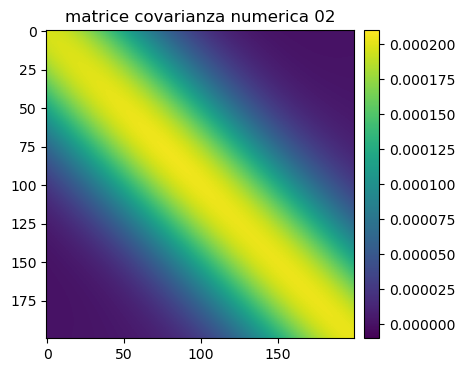

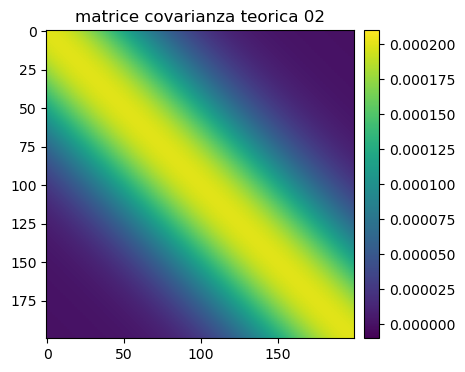

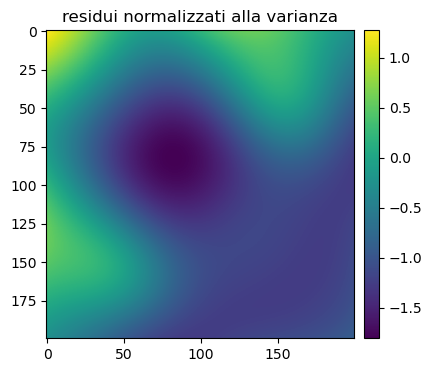

In [66]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_02)*0.05
    cmax =  np.max(cov_th_02)*1.05

    # Plot matrice della covarianza misurata multipolo 02
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 02')
    plt.imshow(cov_xi_02, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 02
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 02')
    plt.imshow(cov_th_02, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_02)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

matrice della covarianza numerica multipolo 04

In [67]:
cov_xi_04 = cov_num_cr(measures0,measures4)

matrice della covarianza teorica multipolo 04

In [68]:
cov_th_04 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_04[i,j] = covf1f2(scale[i],scale[j],sigs[0],ls[0],sigs[2],ls[2])

scarto quadratico medio dei residui normalizzati alla varianza

In [69]:
norm_residuals_04 = np.zeros_like(cov_th_04)
for i in range(Nbins):
    for j in range(Nbins):
        corr_04 = cov_xi_04[i,j]/(np.sqrt(cov_xi_04[i,i]*cov_xi_04[j,j]))
        norm_residuals_04[i,j]=(cov_th_04[i,j]-cov_xi_04[i,j])*np.sqrt((Nmeasures-1)/((1+corr_04)*cov_th_04[i,i]*cov_th_04[j,j]))

rms_deviation_04=np.std(norm_residuals_04)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_04:.3e}')
if rms_deviation_04 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 6.178e-01
**********
* OK *
**********


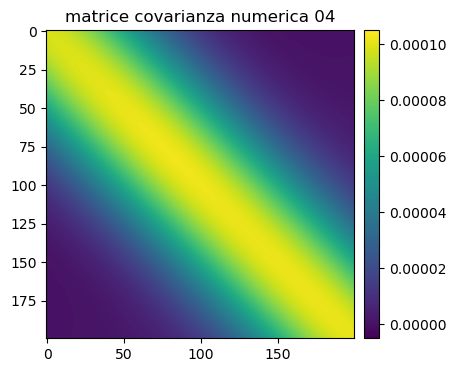

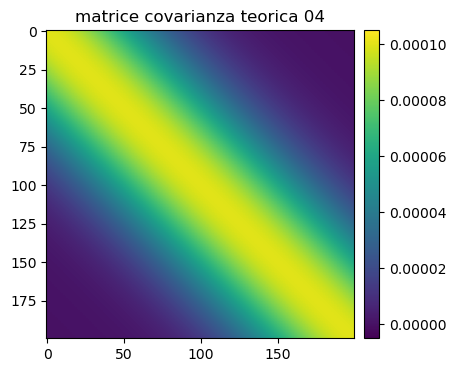

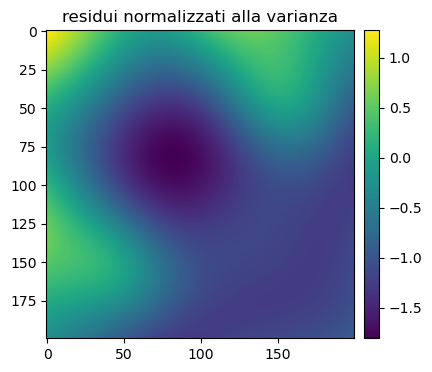

In [70]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_04)*0.05
    cmax =  np.max(cov_th_04)*1.05

    # Plot matrice della covarianza misurata multipolo 04
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 04')
    plt.imshow(cov_xi_04, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 04
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 04')
    plt.imshow(cov_th_04, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_04)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

matrice della covarianza numerica multipolo 24

In [71]:
cov_xi_24 = cov_num_cr(measures2,measures4)

matrice della covarianza teorica multipolo 24

In [72]:
cov_th_24 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_24[i,j] = covf1f2(scale[i],scale[j],sigs[1],ls[1],sigs[2],ls[2])

scarto quadratico medio dei residui normalizzati alla varianza

In [73]:
norm_residuals_24 = np.zeros_like(cov_th_24)
for i in range(Nbins):
    for j in range(Nbins):
        corr_24 = cov_xi_24[i,j]/(np.sqrt(cov_xi_24[i,i]*cov_xi_24[j,j]))
        norm_residuals_24[i,j]=(cov_th_24[i,j]-cov_xi_24[i,j])*np.sqrt((Nmeasures-1)/((1+corr_24)*cov_th_24[i,i]*cov_th_24[j,j]))

rms_deviation_24=np.std(norm_residuals_24)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_24:.3e}')
if rms_deviation_24 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 6.178e-01
**********
* OK *
**********


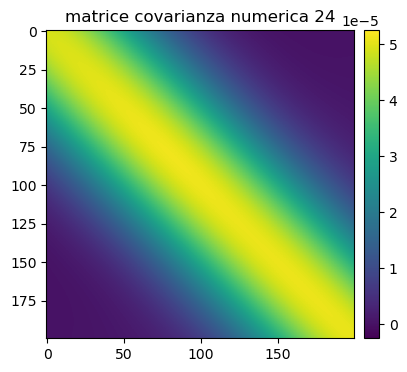

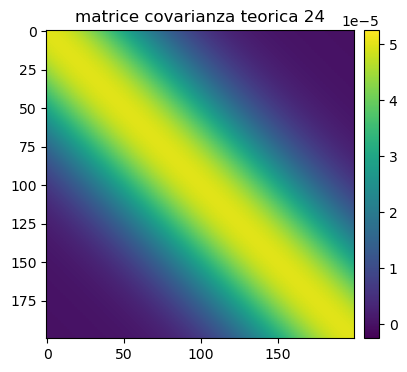

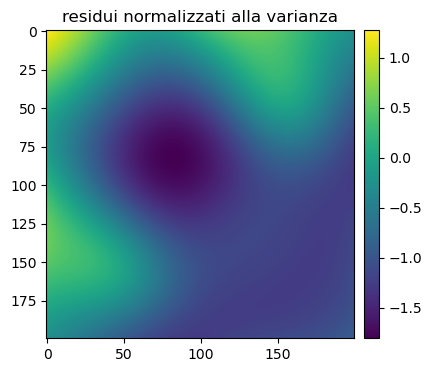

In [74]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_24)*0.05
    cmax =  np.max(cov_th_24)*1.05

    # Plot matrice della covarianza misurata multipolo 24
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 24')
    plt.imshow(cov_xi_24, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 24
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 24')
    plt.imshow(cov_th_24, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_24)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

#### lettura del terzo set dei tre set di misura simulate

In [75]:
test=3

lettura multipolo 0

In [76]:
measures0 = []
for i in np.arange(Nmeasures)+1:
    fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures0.append(table['XI0'])
    if i == 1:
        scale = table['SCALE']
    del table
    file.close()

measures0 = np.asarray(measures0).transpose()

test: controllo array

In [77]:
fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{1}.fits'
file = fits.open(fname)
table = file[1].data.copy()
print(table.shape)

(200,)


In [78]:
measures0.shape

(200, 10000)

calcolo della covarianza numerica e della covarianza numpy

In [79]:
mean_xi_0 = np.mean(measures0,axis=1)
cov_xi_00 = np.cov(measures0)

In [80]:
if TEST_COVARIANCE:
    print('Running test to see if I understand the covariance:')
    cov_mat = cov_num(measures0)
    dif = np.max(np.abs(cov_mat-cov_xi_00))
    # print(f'Largest deviation between my calculation and numpy: {np.max(np.abs(cov_mat-cov_xi))}')
    print(f'Largest deviation between my calculation and numpy: {dif:.3e}')

Running test to see if I understand the covariance:
Largest deviation between my calculation and numpy: 5.664e-13


parametri dei tre set di misure

In [81]:
if test==1:
    sigs = [0.02, 0.02, 0.02]
    ls = [25, 50, 75]
elif test==2:
    sigs = [0.02, 0.01, 0.005]
    ls = [50, 50, 50]
else:
    sigs = [0.02, 0.01, 0.005]
    ls = [5, 5, 5]

matrice della covarianza teorica multipolo 00

In [82]:
cov_th_00 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_00[i,j] = covf(scale[i],scale[j],sigs[0],ls[0])

scarto quadratico medio dei residui normalizzati alla varianza

In [83]:
norm_residuals_00 = np.zeros_like(cov_th_00)
corr_00 = np.zeros_like(cov_th_00)
for i in range(Nbins):
    for j in range(Nbins):
        corr_00[i,j] = cov_xi_00[i,j]/(np.sqrt(cov_xi_00[i,i]*cov_xi_00[j,j]))
        norm_residuals_00[i,j]=(cov_th_00[i,j]-cov_xi_00[i,j])*(np.sqrt((Nmeasures-1)/((1+corr_00[i,j])*cov_th_00[i,i]*cov_th_00[j,j])))

rms_deviation_00=np.std(norm_residuals_00)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_00:.3e}')
if rms_deviation_00 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 9.872e-01
**********
* OK *
**********


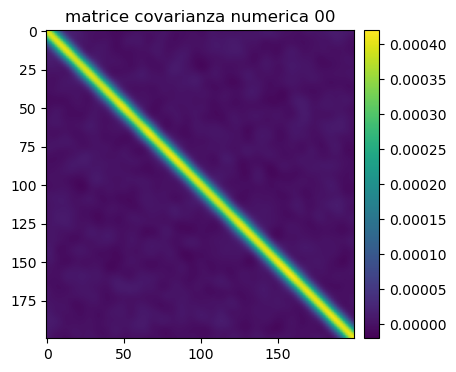

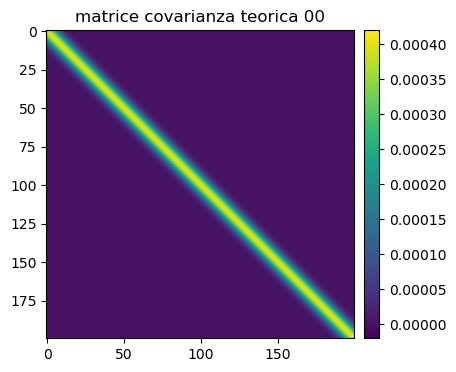

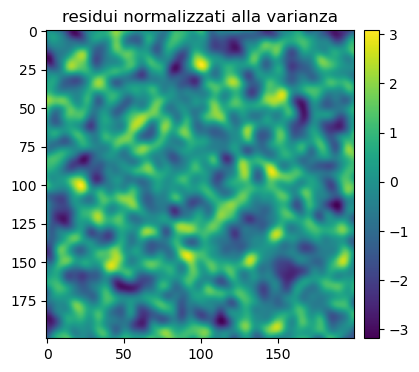

In [84]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_00)*0.05
    cmax =  np.max(cov_th_00)*1.05

    # Plot matrice della covarianza misurata multipolo 00
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 00')
    plt.imshow(cov_xi_00, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 00
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 00')
    plt.imshow(cov_th_00, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_00)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

test

In [85]:
print(cov_xi_00[100,100])
print(cov_xi_00[100,100]*cov_xi_00[100,100])
print(cov_xi_00[100,100]/np.sqrt(cov_xi_00[100,100]*cov_xi_00[100,100]))
print(corr_00[100,100])
print(norm_residuals_00[100,100])

0.00039703008219663766
1.5763288616906886e-07
1.0
1.0
0.5249860033120168


lettura multipolo 2

In [86]:
measures2 = []
for i in np.arange(Nmeasures)+1:
    fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures2.append(table['XI2'])
    file.close()

measures2 = np.asarray(measures2).transpose()

matrice della covarianza numerica multipolo 22

In [87]:
mean_xi_2 = np.mean(measures2,axis=1)
cov_xi_22 = np.cov(measures2)

matrice della covarianza teorica multipolo 22

In [88]:
cov_th_22 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_22[i,j] = covf(scale[i],scale[j],sigs[1],ls[1])

scarto quadratico medio dei residui normalizzati alla varianza

In [89]:
norm_residuals_22 = np.zeros_like(cov_th_22)
for i in range(Nbins):
    for j in range(Nbins):
        corr_22 = cov_xi_22[i,j]/(np.sqrt(cov_xi_22[i,i]*cov_xi_22[j,j]))
        norm_residuals_22[i,j]=(cov_th_22[i,j]-cov_xi_22[i,j])*np.sqrt((Nmeasures-1)/((1+corr_22)*cov_th_22[i,i]*cov_th_22[j,j]))

rms_deviation_22=np.std(norm_residuals_22)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_22:.3e}')
if rms_deviation_22 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 9.872e-01
**********
* OK *
**********


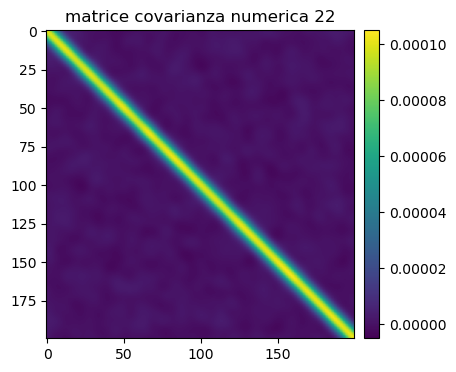

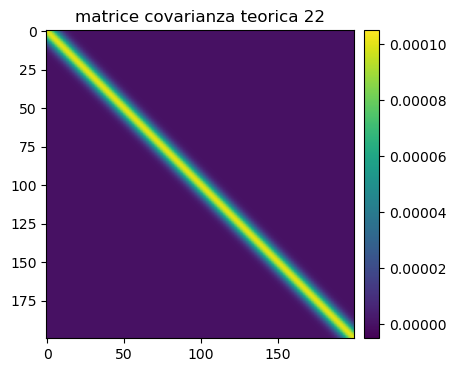

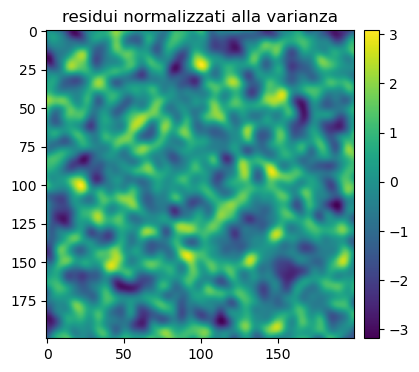

In [90]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_22)*0.05
    cmax =  np.max(cov_th_22)*1.05

    # Plot matrice della covarianza misurata multipolo 22
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 22')
    plt.imshow(cov_xi_22, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 22
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 22')
    plt.imshow(cov_th_22, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_22)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

lettura multipolo 4

In [91]:
measures4 = []
for i in np.arange(Nmeasures)+1:
    fname = f'/home/mario/Scrivania/Abilità_informatiche/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
    
    file = fits.open(fname)
    table = file[1].data.copy()
    measures4.append(table['XI4'])
    file.close()

measures4 = np.asarray(measures4).transpose()

matrice della covarianza numerica multipolo 44

In [92]:
mean_xi_4 = np.mean(measures4,axis=1)
cov_xi_44 = np.cov(measures4)

matrice della covarianza teorica multipolo 44

In [93]:
cov_th_44 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_44[i,j] = covf(scale[i],scale[j],sigs[2],ls[2])

scarto quadratico medio dei residui normalizzati alla varianza

In [94]:
norm_residuals_44 = np.zeros_like(cov_th_44)
for i in range(Nbins):
    for j in range(Nbins):
        corr_44 = cov_xi_44[i,j]/(np.sqrt(cov_xi_44[i,i]*cov_xi_44[j,j]))
        norm_residuals_44[i,j]=(cov_th_44[i,j]-cov_xi_44[i,j])*np.sqrt((Nmeasures-1)/((1+corr_44)*cov_th_44[i,i]*cov_th_44[j,j]))

rms_deviation_44=np.std(norm_residuals_44)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_44:.3e}')
if rms_deviation_44 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 9.872e-01
**********
* OK *
**********


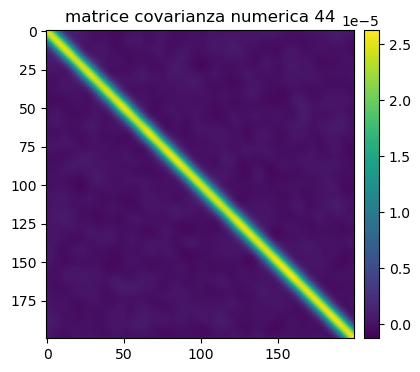

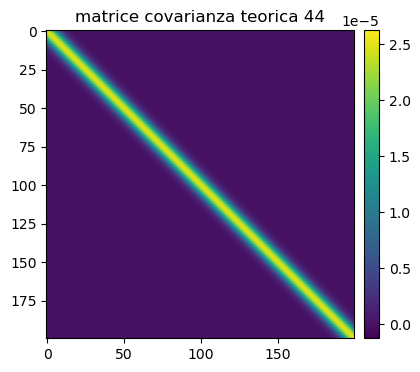

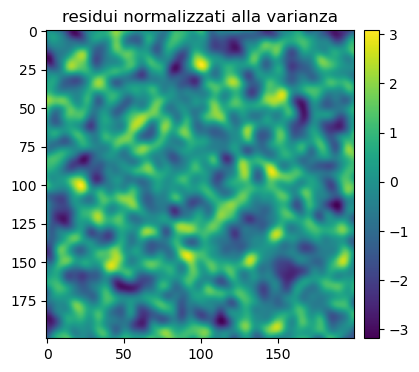

In [95]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_44)*0.05
    cmax =  np.max(cov_th_44)*1.05

    # Plot matrice della covarianza misurata multipolo 44
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 44')
    plt.imshow(cov_xi_44, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 44
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 44')
    plt.imshow(cov_th_44, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_44)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

In [96]:
print(cov_xi_44[100,100])
print(cov_th_44[100,100])
print(cov_xi_44[100,100]*cov_xi_44[100,100])
print(cov_xi_44[100,100]/np.sqrt(cov_xi_44[100,100]*cov_xi_44[100,100]))
#print(corr_44[100,100])
print(norm_residuals_44[100,100])

2.4814380290231543e-05
2.5e-05
6.157534691882316e-10
1.0
0.5249855707492261


cross-correlazioni

matrice della covarianza numerica multipolo 02

In [97]:
cov_xi_02 = cov_num_cr(measures0,measures2)

matrice della covarianza teorica multipolo 02

In [98]:
cov_th_02 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_02[i,j] = covf1f2(scale[i],scale[j],sigs[0],ls[0],sigs[1],ls[1])

scarto quadratico medio dei residui normalizzati alla varianza

In [99]:
norm_residuals_02 = np.zeros_like(cov_th_02)
for i in range(Nbins):
    for j in range(Nbins):
        corr_02 = cov_xi_02[i,j]/(np.sqrt(cov_xi_02[i,i]*cov_xi_02[j,j]))
        norm_residuals_02[i,j]=(cov_th_02[i,j]-cov_xi_02[i,j])*np.sqrt((Nmeasures-1)/((1+corr_02)*cov_th_02[i,i]*cov_th_02[j,j]))

rms_deviation_02=np.std(norm_residuals_02)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_02:.3e}')
if rms_deviation_02 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 9.872e-01
**********
* OK *
**********


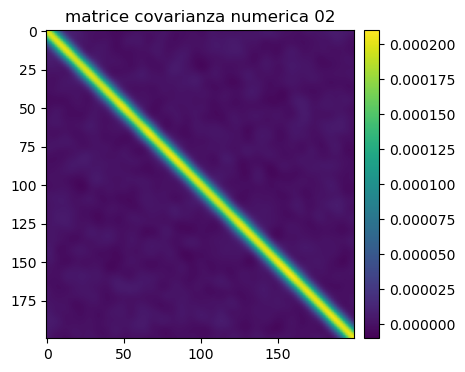

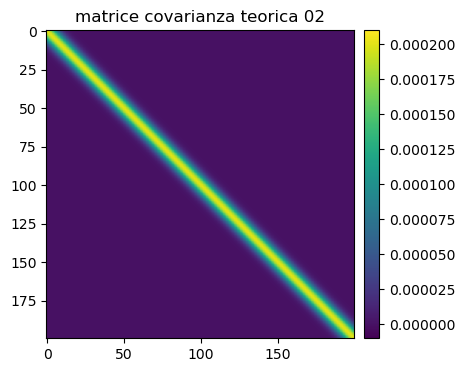

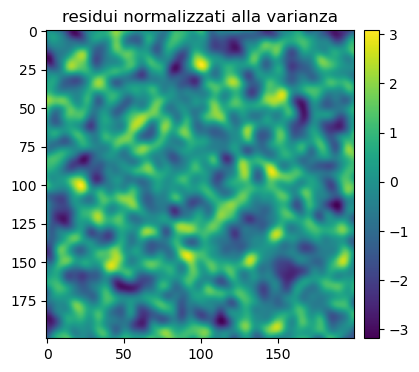

In [100]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_02)*0.05
    cmax =  np.max(cov_th_02)*1.05

    # Plot matrice della covarianza misurata multipolo 02
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 02')
    plt.imshow(cov_xi_02, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 02
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 02')
    plt.imshow(cov_th_02, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_02)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

matrice della covarianza numerica multipolo 04

In [101]:
cov_xi_04 = cov_num_cr(measures0,measures4)

matrice della covarianza teorica multipolo 04

In [102]:
cov_th_04 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_04[i,j] = covf1f2(scale[i],scale[j],sigs[0],ls[0],sigs[2],ls[2])

scarto quadratico medio dei residui normalizzati alla varianza

In [103]:
norm_residuals_04 = np.zeros_like(cov_th_04)
for i in range(Nbins):
    for j in range(Nbins):
        corr_04 = cov_xi_04[i,j]/(np.sqrt(cov_xi_04[i,i]*cov_xi_04[j,j]))
        norm_residuals_04[i,j]=(cov_th_04[i,j]-cov_xi_04[i,j])*np.sqrt((Nmeasures-1)/((1+corr_04)*cov_th_04[i,i]*cov_th_04[j,j]))

rms_deviation_04=np.std(norm_residuals_04)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_04:.3e}')
if rms_deviation_04 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 9.872e-01
**********
* OK *
**********


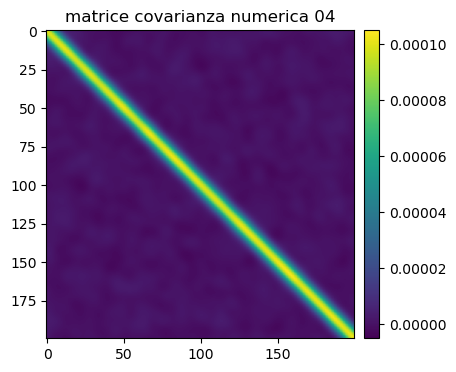

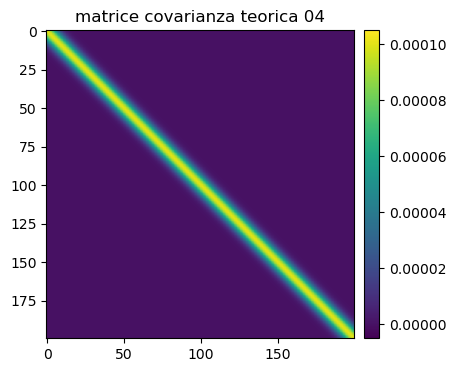

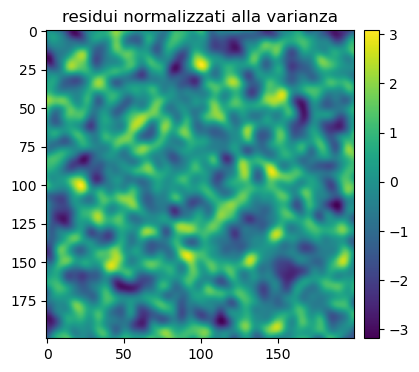

In [104]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_04)*0.05
    cmax =  np.max(cov_th_04)*1.05

    # Plot matrice della covarianza misurata multipolo 04
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 04')
    plt.imshow(cov_xi_04, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 04
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 04')
    plt.imshow(cov_th_04, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_04)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

matrice della covarianza numerica multipolo 24

In [105]:
cov_xi_24 = cov_num_cr(measures2,measures4)

matrice della covarianza teorica multipolo 24

In [106]:
cov_th_24 = np.zeros((Nbins,Nbins),dtype=float)
for i in range(Nbins):
    for j in range(Nbins):
        cov_th_24[i,j] = covf1f2(scale[i],scale[j],sigs[1],ls[1],sigs[2],ls[2])

scarto quadratico medio dei residui normalizzati alla varianza

In [107]:
norm_residuals_24 = np.zeros_like(cov_th_24)
for i in range(Nbins):
    for j in range(Nbins):
        corr_24 = cov_xi_24[i,j]/(np.sqrt(cov_xi_24[i,i]*cov_xi_24[j,j]))
        norm_residuals_24[i,j]=(cov_th_24[i,j]-cov_xi_24[i,j])*np.sqrt((Nmeasures-1)/((1+corr_24)*cov_th_24[i,i]*cov_th_24[j,j]))

rms_deviation_24=np.std(norm_residuals_24)
print(f'scarto quadratico medio dei residui normalizzati: {rms_deviation_24:.3e}')
if rms_deviation_24 < 1.1:
    print("**********")
    print("* OK *")
    print("**********")
else:
    print("!!!!!!!!!!")
    print("! NO !")
    print("!!!!!!!!!!")

scarto quadratico medio dei residui normalizzati: 9.872e-01
**********
* OK *
**********


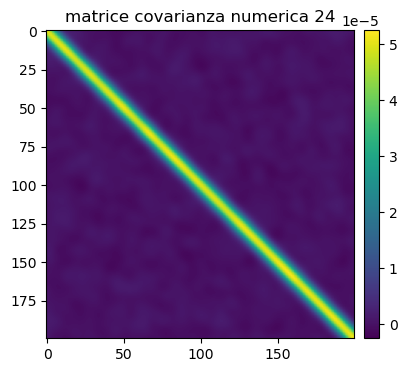

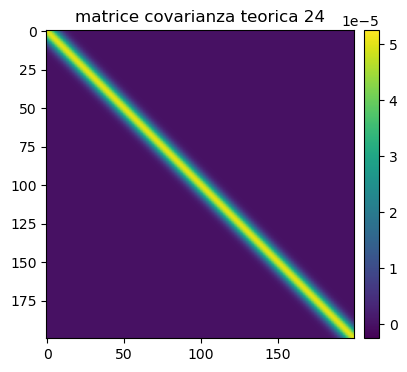

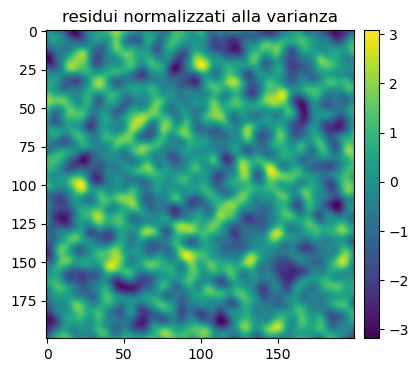

In [108]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th_24)*0.05
    cmax =  np.max(cov_th_24)*1.05

    # Plot matrice della covarianza misurata multipolo 24
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza numerica 24')
    plt.imshow(cov_xi_24, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice della covarianza teorica multipolo 24
    fig = plt.figure(figsize=(6,4))
    plt.title('matrice covarianza teorica 24')
    plt.imshow(cov_th_24, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Plot matrice residui normalizzati alla varianza
    fig = plt.figure(figsize=(6,4))
    plt.title('residui normalizzati alla varianza')
    plt.imshow(norm_residuals_24)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    #cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()